In [1]:
import os
from os.path import join
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.patches import Circle
from matplotlib.path import Path
from matplotlib.patches import PathPatch
import matplotlib
from plottable import ColumnDefinition, Table
from plottable.cmap import normed_cmap
import requests
from io import BytesIO
from PIL import Image
import nfl_data_py as nfl
import logging
from tqdm import tqdm
import sys

sys.path.append('../py')
from preprocess import preprocess

pd.set_option('display.max_columns', None)

LOG = logging.getLogger(__name__)
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

In [2]:
results = pd.read_parquet('../data/results/epa_predictions.parquet')

In [3]:
safeties = (
    results
    .query('sample_type == "original"')
    .groupby('safety_nfl_id', as_index=False)
    .agg({
        'decision_eff_rank_epa': 'mean',
        'decision_eff_rank_epa_int': 'mean',
        'decision_eff_rank_epa_comp': 'mean',
        'gpid': 'nunique'
    })
    .rename(columns={'gpid': 'num_plays'})
)

In [5]:
players = (
    nfl.import_seasonal_rosters(years=[2023])
    [['team','gsis_it_id','player_name','headshot_url']]
    .rename(columns={'gsis_it_id':'safety_nfl_id'})
    .merge(
        nfl.import_team_desc()[['team_abbr','team_logo_espn']].rename(columns={'team_abbr':'team'}),
        on='team',
        how='left'
    )
    .drop_duplicates(subset=['safety_nfl_id'])
    .assign(
        safety_nfl_id=lambda df: df['safety_nfl_id'].astype(int)
    )
)
players.head()

,team,safety_nfl_id,player_name,headshot_url,team_logo_espn
0,PHI,17623,Bernard Williams,None,https://a.espncdn.com/i/teamlogos/nfl/500/phi.png
1,SEA,29550,Jason Peters,https://static.www.nfl.com/image/upload/f_auto...,https://a.espncdn.com/i/teamlogos/nfl/500/sea.png
2,NYJ,29851,Aaron Rodgers,https://static.www.nfl.com/image/private/f_aut...,https://a.espncdn.com/i/teamlogos/nfl/500/nyj.png
3,ARI,31446,Matt Prater,https://static.www.nfl.com/image/private/f_aut...,https://a.espncdn.com/i/teamlogos/nfl/500/ari.png
4,CHI,30842,Marcedes Lewis,https://static.www.nfl.com/image/private/f_aut...,https://a.espncdn.com/i/teamlogos/nfl/500/chi.png


In [6]:
safeties = safeties.merge(
    players,
    on='safety_nfl_id',
    how='left'
)

In [11]:
safeties.query('num_plays >= 30').sort_values('decision_eff_rank_epa_comp', ascending=False, ignore_index=True).head(50)

,safety_nfl_id,decision_eff_rank_epa,decision_eff_rank_epa_int,decision_eff_rank_epa_comp,num_plays,team,player_name,headshot_url,team_logo_espn
0,54502,0.854902,0.825270,0.759504,52,HOU,Jalen Pitre,https://static.www.nfl.com/image/private/f_aut...,https://a.espncdn.com/i/teamlogos/nfl/500/hou.png
1,40107,0.813442,0.746544,0.757817,36,BUF,Micah Hyde,https://static.www.nfl.com/image/private/f_aut...,https://a.espncdn.com/i/teamlogos/nfl/500/buf.png
2,53465,0.783168,0.735779,0.754529,35,MIA,Jevon Holland,https://static.www.nfl.com/image/private/f_aut...,https://a.espncdn.com/i/teamlogos/nfl/500/mia.png
3,47804,0.828681,0.800541,0.740427,32,GB,Darnell Savage,https://static.www.nfl.com/image/private/f_aut...,https://a.espncdn.com/i/teamlogos/nfl/500/gb.png
4,54562,0.781172,0.732657,0.739498,44,DET,Kerby Joseph,https://static.www.nfl.com/image/private/f_aut...,https://a.espncdn.com/i/teamlogos/nfl/500/det.png
5,46080,0.693543,0.675674,0.734855,30,PIT,Minkah Fitzpatrick,https://static.www.nfl.com/image/private/f_aut...,https://a.espncdn.com/i/teamlogos/nfl/500/pit.png
6,52444,0.833325,0.832063,0.724251,36,NYG,Xavier McKinney,https://static.www.nfl.com/image/private/f_aut...,https://a.espncdn.com/i/teamlogos/nfl/500/nyg.png
7,54808,0.829940,0.799511,0.722513,70,PHI,Reed Blankenship,https://static.www.nfl.com/image/private/f_aut...,https://a.espncdn.com/i/teamlogos/nfl/500/phi.png
8,46137,0.826978,0.722411,0.706684,32,KC,Justin Reid,https://static.www.nfl.com/image/private/f_aut...,https://a.espncdn.com/i/teamlogos/nfl/500/kc.png
9,40166,0.761841,0.766282,0.704896,32,BUF,Jordan Poyer,https://static.www.nfl.com/image/private/f_aut...,https://a.espncdn.com/i/teamlogos/nfl/500/buf.png


In [6]:
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from matplotlib.path import Path
from matplotlib.patches import PathPatch

def download_image(url, save_path, playername, team):
    """Download image and make background transparent"""
    try:
        filename = f"{playername.replace(' ', '_').replace('.', '')}_{team}.png"
        filepath = os.path.join(save_path, filename)

        # Skip if already exists
        if os.path.exists(filepath):
            print(f"Skipped {filepath} - already exists")
            return

        # Skip if URL is None
        if url is None:
            print(f"Skipped {playername} - no headshot URL")
            return

        # Download
        response = requests.get(url, stream=True)
        response.raise_for_status()
        img = Image.open(BytesIO(response.content)).convert("RGBA")

        # Get background color (top-left pixel)
        datas = img.getdata()
        new_data = []
        bg_color = datas[0]  # likely green screen background

        for item in datas:
            # Match background color exactly (RGB only)
            if item[:3] == bg_color[:3]:
                new_data.append((255, 255, 255, 0))  # transparent
            else:
                new_data.append(item)

        img.putdata(new_data)
        img.save(filepath, format="PNG")
        print(f"Downloaded and saved transparent image to {filepath}")

    except Exception as e:
        print(f"Error downloading image from {url}: {e}")
        
def circled_image(
    ax: plt.Axes, 
    path: str, 
    *,
    bg_circle: bool = False,
    bg_circle_kwargs: dict = None,
    zoom: float = 0.9,
    **imshow_kwargs
):
    """Plots an image cropped to a circle, aligned to cell center."""
    if not os.path.isfile(path):
        path = os.path.join('../data/images/headshots/blank.png')
    img = plt.imread(path)

    # Crop the image to be a perfect square
    h, w, _ = img.shape
    if h != w:
        min_dim = min(h, w)
        start_h = (h - min_dim) // 2
        start_w = (w - min_dim) // 2
        img = img[start_h:start_h + min_dim, start_w:start_w + min_dim, :]

    # Normalize axes
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.axis("off")

    # Background circle
    if bg_circle:
        bg_kw = {
            "facecolor": "lightgray",
            "edgecolor": "none",
            "zorder": 0
        }
        if bg_circle_kwargs:
            bg_kw.update(bg_circle_kwargs)
        ax.add_patch(Circle((0.5, 0.5), 0.5 * zoom, **bg_kw))

    # Plot image
    im = ax.imshow(img, extent=(0, 1, 0, 1), **imshow_kwargs)

    # Clip to circle
    clip_circle = Circle((0.5, 0.5), 0.5 * zoom, transform=ax.transData)
    im.set_clip_path(clip_circle)

    return im

def regular_image(
    ax: plt.Axes,
    path: str,
    *,
    zoom: float = 0.9,
    **imshow_kwargs
):
    """Plots an image without cropping, aligned to cell center."""
    img = plt.imread(path)

    # Normalize axes
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.axis("off")

    # Plot image
    im = ax.imshow(img, extent=(0, 1, 0, 1), **imshow_kwargs)

    return im

Skipped ../data/images/headshots/Jalen_Pitre_HOU.png - already exists
Skipped ../data/images/headshots/Xavier_McKinney_NYG.png - already exists
Skipped ../data/images/headshots/Reed_Blankenship_PHI.png - already exists
Skipped ../data/images/headshots/Darnell_Savage_GB.png - already exists
Skipped ../data/images/headshots/Justin_Reid_KC.png - already exists
Skipped ../data/images/headshots/Antoine_Winfield_Jr_TB.png - already exists
Skipped ../data/images/headshots/Tashaun_Gipson_SF.png - already exists
Skipped ../data/images/headshots/Camryn_Bynum_MIN.png - already exists
Skipped ../data/images/headshots/Trevon_Moehrig_LV.png - already exists
Skipped ../data/images/headshots/DeShon_Elliott_MIA.png - already exists
Skipped ../data/images/team_logos/ARI_.png - already exists
Skipped ../data/images/team_logos/ATL_.png - already exists
Skipped ../data/images/team_logos/BAL_.png - already exists
Skipped ../data/images/team_logos/BUF_.png - already exists
Skipped ../data/images/team_logos/C

/Users/lukeneuendorf/miniforge3/envs/bdb26/lib/python3.12/site-packages/plottable/table.py:543: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  cell.text.set_bbox(


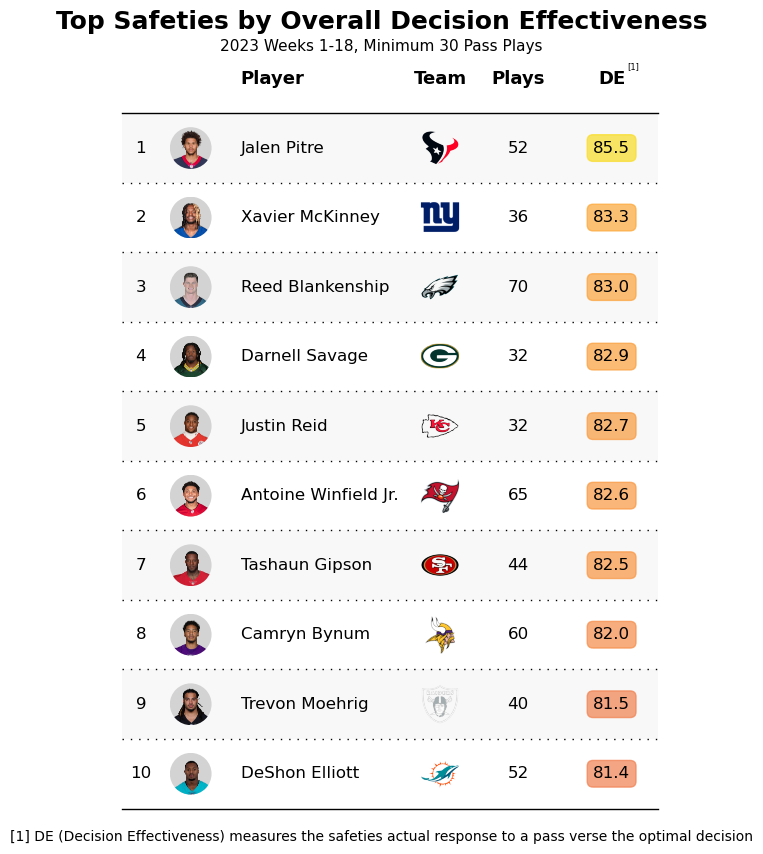

Skipped ../data/images/headshots/Micah_Hyde_BUF.png - already exists
Skipped ../data/images/headshots/Jessie_Bates_ATL.png - already exists
Skipped ../data/images/headshots/Vonn_Bell_CAR.png - already exists
Skipped ../data/images/headshots/Marcus_Williams_BAL.png - already exists
Skipped ../data/images/headshots/Xavier_Woods_CAR.png - already exists
Skipped ../data/images/headshots/Quandre_Diggs_SEA.png - already exists
Skipped ../data/images/headshots/Jordan_Howden_NO.png - already exists
Skipped ../data/images/headshots/John_Johnson_LA.png - already exists
Skipped ../data/images/headshots/Juan_Thornhill_CLE.png - already exists
Skipped ../data/images/headshots/Bryan_Cook_KC.png - already exists
Skipped ../data/images/team_logos/ARI_.png - already exists
Skipped ../data/images/team_logos/ATL_.png - already exists
Skipped ../data/images/team_logos/BAL_.png - already exists
Skipped ../data/images/team_logos/BUF_.png - already exists
Skipped ../data/images/team_logos/CAR_.png - already 

/Users/lukeneuendorf/miniforge3/envs/bdb26/lib/python3.12/site-packages/plottable/table.py:543: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  cell.text.set_bbox(


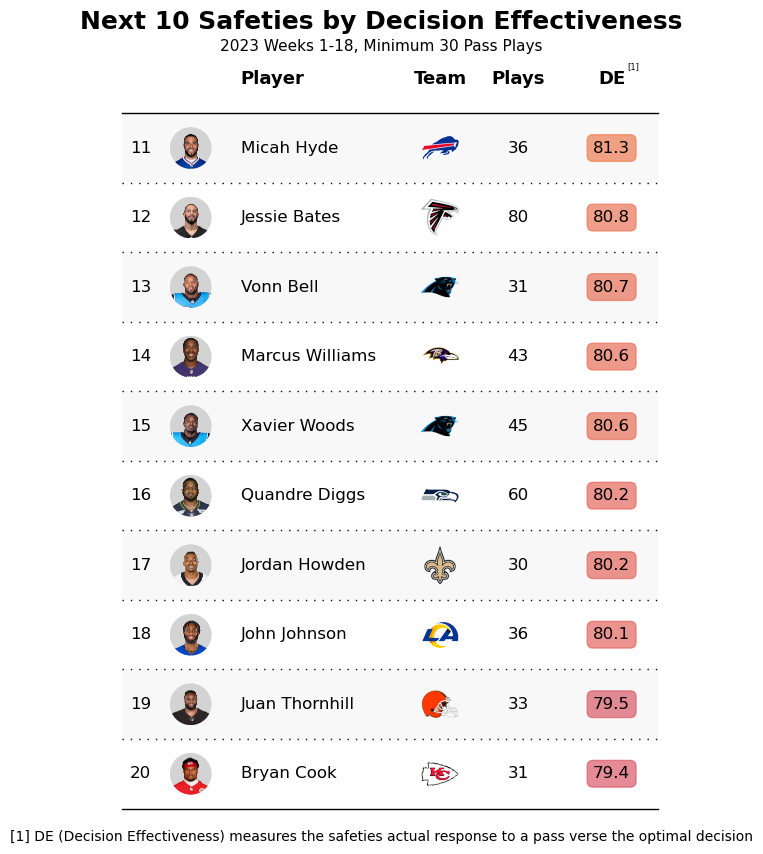

In [7]:
import matplotlib
from plottable import ColumnDefinition, Table
from plottable.cmap import normed_cmap
import requests
from io import BytesIO
from PIL import Image

# Get all safeties with ≥30 snaps
safeties_all30 = safeties[safeties['num_plays'] >= 30]

# Use the same min/max normalization for all tables
all_values = safeties_all30["decision_eff_rank_epa"].multiply(100)


safeties_t20 = (
    safeties
    [safeties['num_plays'] >= 30]
    .sort_values('decision_eff_rank_epa', ascending=False)
    .assign(
        decision_eff_rank_epa=lambda df: df['decision_eff_rank_epa'].multiply(100).round(1)
    )
    .reset_index(drop=True)
    .head(10)
)

safeties_t20.insert(0, "Rank", range(1, len(safeties_t20) + 1))
safeties_t20.set_index('Rank', inplace=True)

DATA_DIR = '../data'
HEADSHOT_DIR = join(DATA_DIR, 'images', 'headshots')
os.makedirs(HEADSHOT_DIR, exist_ok=True)


for row in safeties_t20.itertuples():
    download_image(
        row.headshot_url,
        HEADSHOT_DIR,
        row.player_name,
        row.team
    )

safeties_t20['headshot_path'] = safeties_t20.apply(
    lambda row: os.path.join(
        HEADSHOT_DIR,
        f"{row.player_name.replace(' ', '_').replace('.','')}_{row.team}.png"
    ),
    axis=1
)

teams = nfl.import_team_desc()

TEAM_LOGO_DIR = join(DATA_DIR, 'images', 'team_logos')
os.makedirs(TEAM_LOGO_DIR, exist_ok=True)
for row in teams.itertuples():
    download_image(
        row.team_logo_espn,
        TEAM_LOGO_DIR,
        row.team_abbr,
        ""
    )

safeties_t20['team_logo_path'] = safeties_t20.apply(
    lambda row: os.path.join(
        TEAM_LOGO_DIR,
        f"{row.team}_.png"
    ),
    axis=1
)

col_defs = [
    ColumnDefinition(
        name="Rank",
        title="",
        textprops={"ha": "center", "weight": "normal"},
        width=0.3,
    ),
    ColumnDefinition(
        name="headshot_path",
        title="",
        textprops={"ha": "right"},
        width=.5,
        plot_fn=lambda ax, val: circled_image(
            ax, 
            val,
            bg_circle=True,
            zoom=1.0,
        )
    ),
    ColumnDefinition(
        name="player_name",
        title="Player",
        textprops={"ha": "left", "weight": "normal"},
        width=1.5,
    ),
    ColumnDefinition(
        name="team_logo_path",
        title="Team",
        textprops={"ha": "center"},
        width=0.5,
        plot_fn=lambda ax, val: regular_image(
            ax, 
            val,
            zoom=0.8,        
        )
    ),
    ColumnDefinition(
        name="num_plays",
        title="Plays",
        textprops={"ha": "center"},
        width=0.75,
    ),
    ColumnDefinition(
        name="decision_eff_rank_epa",
        title="DE",
        textprops={
            "ha": "center",
            "bbox": {"boxstyle": "round,pad=0.35", "edgecolor": "none", "alpha": 0.7},
        },
        formatter=lambda x: f"{x:.1f}",
        cmap=normed_cmap(all_values, cmap=matplotlib.cm.plasma, num_stds=2.5),
        width=0.75,
    )
]

# Figure setup
plt.rcParams["font.family"] = ["DejaVu Sans"]
fig, ax = plt.subplots(figsize=(7, 10))

cols = ["headshot_path", "player_name", "team_logo_path", "num_plays", "decision_eff_rank_epa"]

table = Table(
    safeties_t20[cols],
    column_definitions=col_defs,
    row_dividers=True,
    footer_divider=True,
    ax=ax,
    textprops={"fontsize": 12, "weight": "normal"},
    row_divider_kw={"linewidth": 1, "linestyle": (0, (1, 5))},
    col_label_divider_kw={"linewidth": 1, "linestyle": "-"},
    column_border_kw={"linewidth": 1, "linestyle": "-"},
    even_row_color="#f8f8f8",  # Light gray for even rows
)
# Make only the column headers bold (and optionally tweak size)
for cell in table.col_label_row.cells:
    if hasattr(cell, "text") and cell.text is not None:
        cell.text.set_fontweight("bold")
        cell.text.set_fontsize(13)

# Title & footer
fig.suptitle(
    "Top Safeties by Overall Decision Effectiveness",
    fontsize=18,
    fontweight="bold",
    y=0.9,
    ha="center", va="center",
)

# Subtitle
fig.text(
    0.5, 0.876,  # Position just below main title
    "2023 Weeks 1-18, Minimum 30 Pass Plays",
    fontsize=11,
    ha="center", va="center"
)

fig.text(
    0.5, 0.085,
    "[1] DE (Decision Effectiveness) measures the safeties actual response to a pass verse the optimal decision",
    ha="center", va="center", fontsize=10
)

fig.text(
    0.86, 0.855,
    "[1]",
    ha="center", va="center", fontsize=6
)


os.makedirs('../results/safety_rankings', exist_ok=True)
plt.savefig('../results/safety_rankings/overall_t10.png', bbox_inches='tight', dpi=300)

plt.show()
import matplotlib
from plottable import ColumnDefinition, Table
from plottable.cmap import normed_cmap
import requests
from io import BytesIO
from PIL import Image

safeties_t20 = (
    safeties
    [safeties['num_plays'] >= 30]
    .sort_values('decision_eff_rank_epa', ascending=False)
    .assign(
        decision_eff_rank_epa=lambda df: df['decision_eff_rank_epa'].multiply(100).round(1)
    )
    .reset_index(drop=True)
    .iloc[10:20]  # Get the next 10 after the top 10
)

safeties_t20.insert(0, "Rank", range(11, 21))
safeties_t20.set_index('Rank', inplace=True)

HEADSHOT_DIR = join(DATA_DIR, 'images', 'headshots')
os.makedirs(HEADSHOT_DIR, exist_ok=True)


for row in safeties_t20.itertuples():
    download_image(
        row.headshot_url,
        HEADSHOT_DIR,
        row.player_name,
        row.team
    )

safeties_t20['headshot_path'] = safeties_t20.apply(
    lambda row: os.path.join(
        HEADSHOT_DIR,
        f"{row.player_name.replace(' ', '_').replace('.','')}_{row.team}.png"
    ),
    axis=1
)

teams = nfl.import_team_desc()

TEAM_LOGO_DIR = join(DATA_DIR, 'images', 'team_logos')
os.makedirs(TEAM_LOGO_DIR, exist_ok=True)
for row in teams.itertuples():
    download_image(
        row.team_logo_espn,
        TEAM_LOGO_DIR,
        row.team_abbr,
        ""
    )

safeties_t20['team_logo_path'] = safeties_t20.apply(
    lambda row: os.path.join(
        TEAM_LOGO_DIR,
        f"{row.team}_.png"
    ),
    axis=1
)

col_defs = [
    ColumnDefinition(
        name="Rank",
        title="",
        textprops={"ha": "center", "weight": "normal"},
        width=0.3,
    ),
    ColumnDefinition(
        name="headshot_path",
        title="",
        textprops={"ha": "right"},
        width=.5,
        plot_fn=lambda ax, val: circled_image(
            ax, 
            val,
            bg_circle=True,
            zoom=1.0,
        )
    ),
    ColumnDefinition(
        name="player_name",
        title="Player",
        textprops={"ha": "left", "weight": "normal"},
        width=1.5,
    ),
    ColumnDefinition(
        name="team_logo_path",
        title="Team",
        textprops={"ha": "center"},
        width=0.5,
        plot_fn=lambda ax, val: regular_image(
            ax, 
            val,
            zoom=0.8,        
        )
    ),
    ColumnDefinition(
        name="num_plays",
        title="Plays",
        textprops={"ha": "center"},
        width=0.75,
    ),
    ColumnDefinition(
        name="decision_eff_rank_epa",
        title="DE",
        textprops={
            "ha": "center",
            "bbox": {"boxstyle": "round,pad=0.35", "edgecolor": "none", "alpha": 0.7},
        },
        formatter=lambda x: f"{x:.1f}",
        cmap=normed_cmap(all_values, cmap=matplotlib.cm.plasma, num_stds=2.5),
        width=0.75,
    )
]

# Figure setup
plt.rcParams["font.family"] = ["DejaVu Sans"]
fig, ax = plt.subplots(figsize=(7, 10))

cols = ["headshot_path", "player_name", "team_logo_path", "num_plays", "decision_eff_rank_epa"]

table = Table(
    safeties_t20[cols],
    column_definitions=col_defs,
    row_dividers=True,
    footer_divider=True,
    ax=ax,
    textprops={"fontsize": 12, "weight": "normal"},
    row_divider_kw={"linewidth": 1, "linestyle": (0, (1, 5))},
    col_label_divider_kw={"linewidth": 1, "linestyle": "-"},
    column_border_kw={"linewidth": 1, "linestyle": "-"},
    even_row_color="#f8f8f8",  # Light gray for even rows
)
# Make only the column headers bold (and optionally tweak size)
for cell in table.col_label_row.cells:
    if hasattr(cell, "text") and cell.text is not None:
        cell.text.set_fontweight("bold")
        cell.text.set_fontsize(13)

# Title & footer
fig.suptitle(
    "Next 10 Safeties by Decision Effectiveness",
    fontsize=18,
    fontweight="bold",
    y=0.9,
    ha="center", va="center",
)

# Subtitle
fig.text(
    0.5, 0.876,  # Position just below main title
    "2023 Weeks 1-18, Minimum 30 Pass Plays",
    fontsize=11,
    ha="center", va="center"
)

fig.text(
    0.5, 0.085,
    "[1] DE (Decision Effectiveness) measures the safeties actual response to a pass verse the optimal decision",
    ha="center", va="center", fontsize=10
)

fig.text(
    0.86, 0.855,
    "[1]",
    ha="center", va="center", fontsize=6
)

os.makedirs('../results/safety_rankings', exist_ok=True)
plt.savefig('../results/safety_rankings/overall_t10_t20.png', bbox_inches='tight', dpi=300)

plt.show()

Skipped ../data/images/headshots/Xavier_McKinney_NYG.png - already exists
Skipped ../data/images/headshots/Jalen_Pitre_HOU.png - already exists
Skipped ../data/images/headshots/Trevon_Moehrig_LV.png - already exists
Skipped ../data/images/headshots/Antoine_Winfield_Jr_TB.png - already exists
Skipped ../data/images/headshots/Camryn_Bynum_MIN.png - already exists
Skipped ../data/images/headshots/Tashaun_Gipson_SF.png - already exists
Skipped ../data/images/headshots/Darnell_Savage_GB.png - already exists
Skipped ../data/images/headshots/Reed_Blankenship_PHI.png - already exists
Skipped ../data/images/headshots/Rodney_Thomas_IND.png - already exists
Skipped ../data/images/headshots/Marcus_Williams_BAL.png - already exists
Skipped ../data/images/team_logos/ARI_.png - already exists
Skipped ../data/images/team_logos/ATL_.png - already exists
Skipped ../data/images/team_logos/BAL_.png - already exists
Skipped ../data/images/team_logos/BUF_.png - already exists
Skipped ../data/images/team_log

/Users/lukeneuendorf/miniforge3/envs/bdb26/lib/python3.12/site-packages/plottable/table.py:543: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  cell.text.set_bbox(


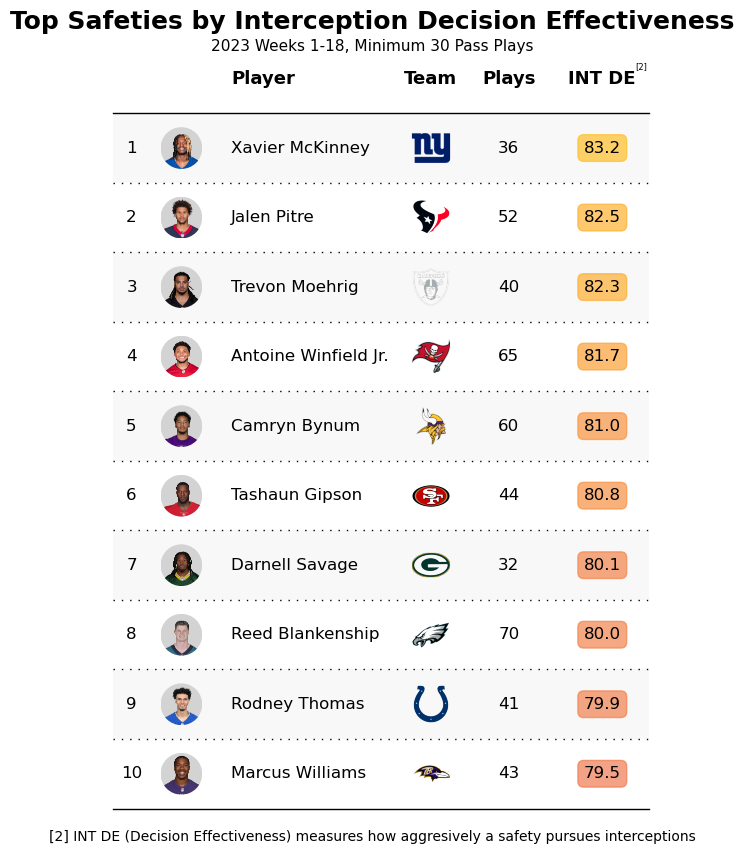

Skipped ../data/images/headshots/DeShon_Elliott_MIA.png - already exists
Skipped ../data/images/headshots/Percy_Butler_WAS.png - already exists
Skipped ../data/images/headshots/Xavier_Woods_CAR.png - already exists
Skipped ../data/images/headshots/Tyrann_Mathieu_NO.png - already exists
Skipped ../data/images/headshots/Jordan_Howden_NO.png - already exists
Skipped ../data/images/headshots/Jabrill_Peppers_NE.png - already exists
Skipped ../data/images/headshots/Bryan_Cook_KC.png - already exists
Skipped ../data/images/headshots/Rayshawn_Jenkins_JAX.png - already exists
Skipped ../data/images/headshots/Quandre_Diggs_SEA.png - already exists
Skipped ../data/images/headshots/Jordan_Fuller_LA.png - already exists
Skipped ../data/images/team_logos/ARI_.png - already exists
Skipped ../data/images/team_logos/ATL_.png - already exists
Skipped ../data/images/team_logos/BAL_.png - already exists
Skipped ../data/images/team_logos/BUF_.png - already exists
Skipped ../data/images/team_logos/CAR_.png 

/Users/lukeneuendorf/miniforge3/envs/bdb26/lib/python3.12/site-packages/plottable/table.py:543: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  cell.text.set_bbox(


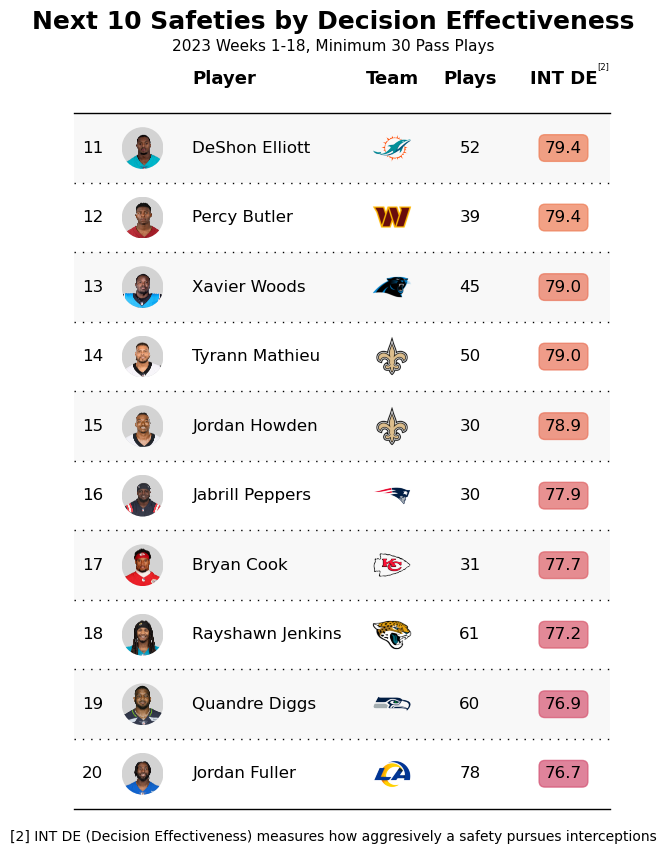

In [8]:
import matplotlib
from plottable import ColumnDefinition, Table
from plottable.cmap import normed_cmap
import requests
from io import BytesIO
from PIL import Image

# Get all safeties with ≥30 snaps
safeties_all30 = safeties[safeties['num_plays'] >= 30]

# Use the same min/max normalization for all tables
all_values = safeties_all30["decision_eff_rank_epa_int"].multiply(100)

safeties_t20 = (
    safeties
    [safeties['num_plays'] >= 30]
    .sort_values('decision_eff_rank_epa_int', ascending=False)
    .assign(
        decision_eff_rank_epa_int=lambda df: df['decision_eff_rank_epa_int'].multiply(100).round(1)
    )
    .reset_index(drop=True)
    .head(10)
)

safeties_t20.insert(0, "Rank", range(1, len(safeties_t20) + 1))
safeties_t20.set_index('Rank', inplace=True)

DATA_DIR = '../data'
HEADSHOT_DIR = join(DATA_DIR, 'images', 'headshots')
os.makedirs(HEADSHOT_DIR, exist_ok=True)


for row in safeties_t20.itertuples():
    download_image(
        row.headshot_url,
        HEADSHOT_DIR,
        row.player_name,
        row.team
    )

safeties_t20['headshot_path'] = safeties_t20.apply(
    lambda row: os.path.join(
        HEADSHOT_DIR,
        f"{row.player_name.replace(' ', '_').replace('.','')}_{row.team}.png"
    ),
    axis=1
)

teams = nfl.import_team_desc()

TEAM_LOGO_DIR = join(DATA_DIR, 'images', 'team_logos')
os.makedirs(TEAM_LOGO_DIR, exist_ok=True)
for row in teams.itertuples():
    download_image(
        row.team_logo_espn,
        TEAM_LOGO_DIR,
        row.team_abbr,
        ""
    )

safeties_t20['team_logo_path'] = safeties_t20.apply(
    lambda row: os.path.join(
        TEAM_LOGO_DIR,
        f"{row.team}_.png"
    ),
    axis=1
)

col_defs = [
    ColumnDefinition(
        name="Rank",
        title="",
        textprops={"ha": "center", "weight": "normal"},
        width=0.3,
    ),
    ColumnDefinition(
        name="headshot_path",
        title="",
        textprops={"ha": "right"},
        width=.5,
        plot_fn=lambda ax, val: circled_image(
            ax, 
            val,
            bg_circle=True,
            zoom=1.0,
        )
    ),
    ColumnDefinition(
        name="player_name",
        title="Player",
        textprops={"ha": "left", "weight": "normal"},
        width=1.5,
    ),
    ColumnDefinition(
        name="team_logo_path",
        title="Team",
        textprops={"ha": "center"},
        width=0.5,
        plot_fn=lambda ax, val: regular_image(
            ax, 
            val,
            zoom=0.8,        
        )
    ),
    ColumnDefinition(
        name="num_plays",
        title="Plays",
        textprops={"ha": "center"},
        width=0.75,
    ),
    ColumnDefinition(
        name="decision_eff_rank_epa_int",
        title="INT DE",
        textprops={
            "ha": "center",
            "bbox": {"boxstyle": "round,pad=0.35", "edgecolor": "none", "alpha": 0.7},
        },
        formatter=lambda x: f"{x:.1f}",
        cmap=normed_cmap(all_values, cmap=matplotlib.cm.plasma, num_stds=2.5),
        width=0.75,
    )
]

# Figure setup
plt.rcParams["font.family"] = ["DejaVu Sans"]
fig, ax = plt.subplots(figsize=(7, 10))

cols = ["headshot_path", "player_name", "team_logo_path", "num_plays", "decision_eff_rank_epa_int"]

table = Table(
    safeties_t20[cols],
    column_definitions=col_defs,
    row_dividers=True,
    footer_divider=True,
    ax=ax,
    textprops={"fontsize": 12, "weight": "normal"},
    row_divider_kw={"linewidth": 1, "linestyle": (0, (1, 5))},
    col_label_divider_kw={"linewidth": 1, "linestyle": "-"},
    column_border_kw={"linewidth": 1, "linestyle": "-"},
    even_row_color="#f8f8f8",  # Light gray for even rows
)
# Make only the column headers bold (and optionally tweak size)
for cell in table.col_label_row.cells:
    if hasattr(cell, "text") and cell.text is not None:
        cell.text.set_fontweight("bold")
        cell.text.set_fontsize(13)

# Title & footer
fig.suptitle(
    "Top Safeties by Interception Decision Effectiveness",
    fontsize=18,
    fontweight="bold",
    y=0.9,
    ha="center", va="center",
)

# Subtitle
fig.text(
    0.5, 0.876,  # Position just below main title
    "2023 Weeks 1-18, Minimum 30 Pass Plays",
    fontsize=11,
    ha="center", va="center"
)

fig.text(
    0.5, 0.085,
    "[2] INT DE (Decision Effectiveness) measures how aggresively a safety pursues interceptions",
    ha="center", va="center", fontsize=10
)

fig.text(
    0.885, 0.855,
    "[2]",
    ha="center", va="center", fontsize=6
)


os.makedirs('../results/safety_rankings', exist_ok=True)
plt.savefig('../results/safety_rankings/int_t10.png', bbox_inches='tight', dpi=300)

plt.show()
import matplotlib
from plottable import ColumnDefinition, Table
from plottable.cmap import normed_cmap
import requests
from io import BytesIO
from PIL import Image

safeties_t20 = (
    safeties
    [safeties['num_plays'] >= 30]
    .sort_values('decision_eff_rank_epa_int', ascending=False)
    .assign(
        decision_eff_rank_epa_int=lambda df: df['decision_eff_rank_epa_int'].multiply(100).round(1)
    )
    .reset_index(drop=True)
    .iloc[10:20]  # Get the next 10 after the top 10
)

safeties_t20.insert(0, "Rank", range(11, 21))
safeties_t20.set_index('Rank', inplace=True)

HEADSHOT_DIR = join(DATA_DIR, 'images', 'headshots')
os.makedirs(HEADSHOT_DIR, exist_ok=True)


for row in safeties_t20.itertuples():
    download_image(
        row.headshot_url,
        HEADSHOT_DIR,
        row.player_name,
        row.team
    )

safeties_t20['headshot_path'] = safeties_t20.apply(
    lambda row: os.path.join(
        HEADSHOT_DIR,
        f"{row.player_name.replace(' ', '_').replace('.','')}_{row.team}.png"
    ),
    axis=1
)

teams = nfl.import_team_desc()

TEAM_LOGO_DIR = join(DATA_DIR, 'images', 'team_logos')
os.makedirs(TEAM_LOGO_DIR, exist_ok=True)
for row in teams.itertuples():
    download_image(
        row.team_logo_espn,
        TEAM_LOGO_DIR,
        row.team_abbr,
        ""
    )

safeties_t20['team_logo_path'] = safeties_t20.apply(
    lambda row: os.path.join(
        TEAM_LOGO_DIR,
        f"{row.team}_.png"
    ),
    axis=1
)

col_defs = [
    ColumnDefinition(
        name="Rank",
        title="",
        textprops={"ha": "center", "weight": "normal"},
        width=0.3,
    ),
    ColumnDefinition(
        name="headshot_path",
        title="",
        textprops={"ha": "right"},
        width=.5,
        plot_fn=lambda ax, val: circled_image(
            ax, 
            val,
            bg_circle=True,
            zoom=1.0,
        )
    ),
    ColumnDefinition(
        name="player_name",
        title="Player",
        textprops={"ha": "left", "weight": "normal"},
        width=1.5,
    ),
    ColumnDefinition(
        name="team_logo_path",
        title="Team",
        textprops={"ha": "center"},
        width=0.5,
        plot_fn=lambda ax, val: regular_image(
            ax, 
            val,
            zoom=0.8,        
        )
    ),
    ColumnDefinition(
        name="num_plays",
        title="Plays",
        textprops={"ha": "center"},
        width=0.75,
    ),
    ColumnDefinition(
        name="decision_eff_rank_epa_int",
        title="INT DE",
        textprops={
            "ha": "center",
            "bbox": {"boxstyle": "round,pad=0.35", "edgecolor": "none", "alpha": 0.7},
        },
        formatter=lambda x: f"{x:.1f}",
        cmap=normed_cmap(all_values, cmap=matplotlib.cm.plasma, num_stds=2.5),
        width=0.75,
    )
]

# Figure setup
plt.rcParams["font.family"] = ["DejaVu Sans"]
fig, ax = plt.subplots(figsize=(7, 10))

cols = ["headshot_path", "player_name", "team_logo_path", "num_plays", "decision_eff_rank_epa_int"]

table = Table(
    safeties_t20[cols],
    column_definitions=col_defs,
    row_dividers=True,
    footer_divider=True,
    ax=ax,
    textprops={"fontsize": 12, "weight": "normal"},
    row_divider_kw={"linewidth": 1, "linestyle": (0, (1, 5))},
    col_label_divider_kw={"linewidth": 1, "linestyle": "-"},
    column_border_kw={"linewidth": 1, "linestyle": "-"},
    even_row_color="#f8f8f8",  # Light gray for even rows
)
# Make only the column headers bold (and optionally tweak size)
for cell in table.col_label_row.cells:
    if hasattr(cell, "text") and cell.text is not None:
        cell.text.set_fontweight("bold")
        cell.text.set_fontsize(13)

# Title & footer
fig.suptitle(
    "Next 10 Safeties by Decision Effectiveness",
    fontsize=18,
    fontweight="bold",
    y=0.9,
    ha="center", va="center",
)

# Subtitle
fig.text(
    0.5, 0.876,  # Position just below main title
    "2023 Weeks 1-18, Minimum 30 Pass Plays",
    fontsize=11,
    ha="center", va="center"
)

fig.text(
    0.5, 0.085,
    "[2] INT DE (Decision Effectiveness) measures how aggresively a safety pursues interceptions",
    ha="center", va="center", fontsize=10
)

fig.text(
    0.885, 0.855,
    "[2]",
    ha="center", va="center", fontsize=6
)

os.makedirs('../results/safety_rankings', exist_ok=True)
plt.savefig('../results/safety_rankings/int_t10_t20.png', bbox_inches='tight', dpi=300)

plt.show()

Skipped ../data/images/headshots/Jalen_Pitre_HOU.png - already exists
Skipped ../data/images/headshots/Micah_Hyde_BUF.png - already exists
Skipped ../data/images/headshots/Jevon_Holland_MIA.png - already exists
Skipped ../data/images/headshots/Darnell_Savage_GB.png - already exists
Skipped ../data/images/headshots/Kerby_Joseph_DET.png - already exists
Skipped ../data/images/headshots/Minkah_Fitzpatrick_PIT.png - already exists
Skipped ../data/images/headshots/Xavier_McKinney_NYG.png - already exists
Skipped ../data/images/headshots/Reed_Blankenship_PHI.png - already exists
Skipped ../data/images/headshots/Justin_Reid_KC.png - already exists
Skipped ../data/images/headshots/Jordan_Poyer_BUF.png - already exists
Skipped ../data/images/team_logos/ARI_.png - already exists
Skipped ../data/images/team_logos/ATL_.png - already exists
Skipped ../data/images/team_logos/BAL_.png - already exists
Skipped ../data/images/team_logos/BUF_.png - already exists
Skipped ../data/images/team_logos/CAR_.p

/Users/lukeneuendorf/miniforge3/envs/bdb26/lib/python3.12/site-packages/plottable/table.py:543: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  cell.text.set_bbox(


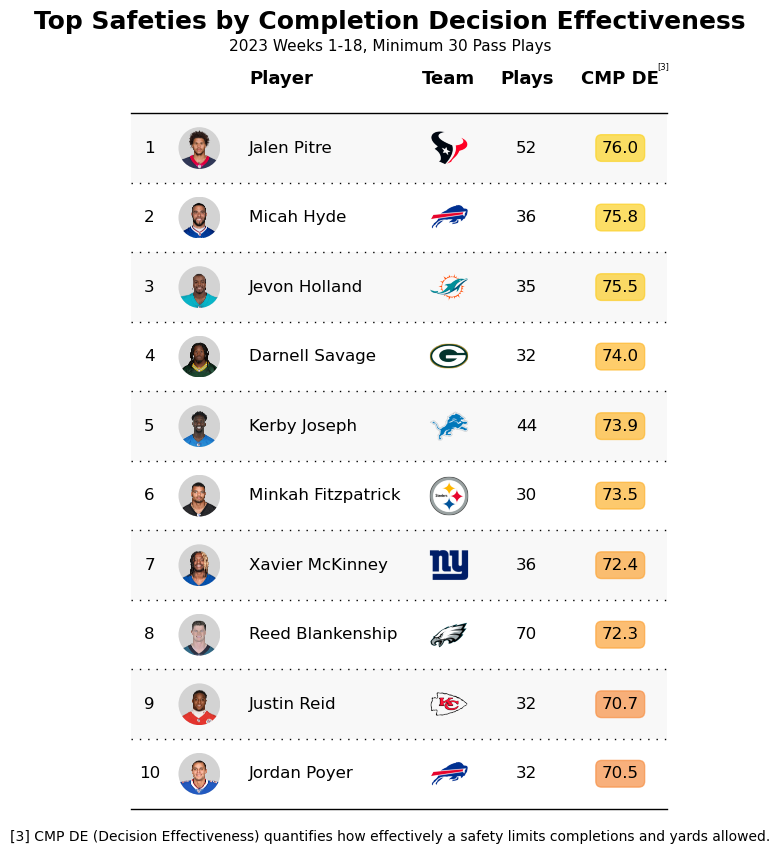

Skipped ../data/images/headshots/Justin_Simmons_DEN.png - already exists
Skipped ../data/images/headshots/John_Johnson_LA.png - already exists
Skipped ../data/images/headshots/Kamren_Curl_WAS.png - already exists
Skipped ../data/images/headshots/Damontae_Kazee_PIT.png - already exists
Skipped ../data/images/headshots/Jason_Pinnock_NYG.png - already exists
Skipped ../data/images/headshots/Kyle_Dugger_NE.png - already exists
Skipped ../data/images/headshots/K'Von_Wallace_TEN.png - already exists
Skipped ../data/images/headshots/Jaquan_Brisker_CHI.png - already exists
Skipped ../data/images/headshots/Quandre_Diggs_SEA.png - already exists
Skipped ../data/images/headshots/Bryan_Cook_KC.png - already exists
Skipped ../data/images/team_logos/ARI_.png - already exists
Skipped ../data/images/team_logos/ATL_.png - already exists
Skipped ../data/images/team_logos/BAL_.png - already exists
Skipped ../data/images/team_logos/BUF_.png - already exists
Skipped ../data/images/team_logos/CAR_.png - alr

/Users/lukeneuendorf/miniforge3/envs/bdb26/lib/python3.12/site-packages/plottable/table.py:543: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  cell.text.set_bbox(


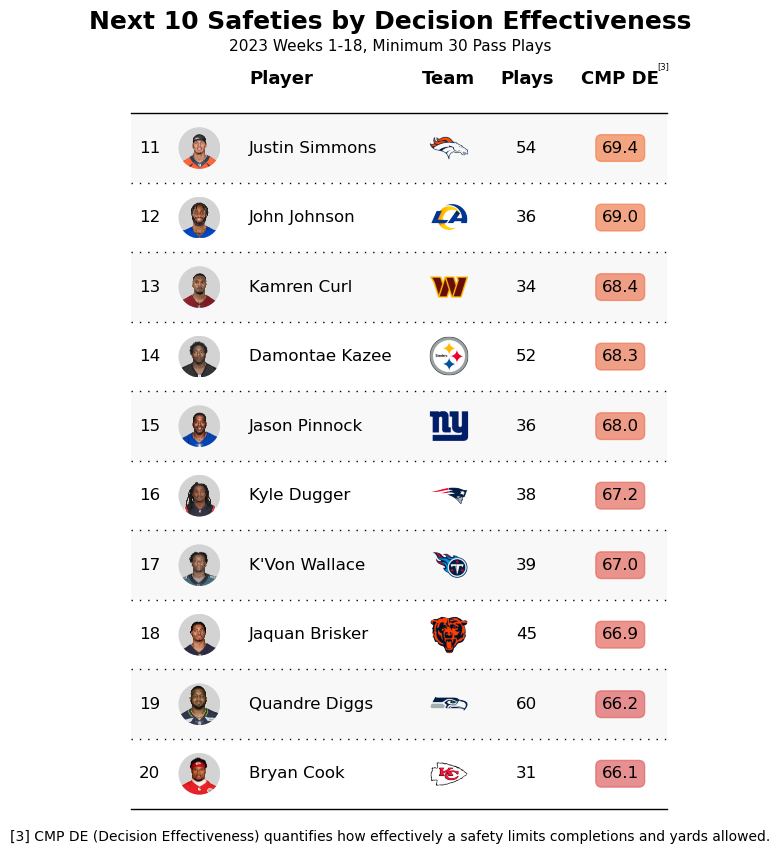

In [9]:
import matplotlib
from plottable import ColumnDefinition, Table
from plottable.cmap import normed_cmap
import requests
from io import BytesIO
from PIL import Image

# Get all safeties with ≥30 snaps
safeties_all30 = safeties[safeties['num_plays'] >= 30]

# Use the same min/max normalization for all tables
all_values = safeties_all30["decision_eff_rank_epa_comp"].multiply(100)

safeties_t20 = (
    safeties
    [safeties['num_plays'] >= 30]
    .sort_values('decision_eff_rank_epa_comp', ascending=False)
    .assign(
        decision_eff_rank_epa_comp=lambda df: df['decision_eff_rank_epa_comp'].multiply(100).round(1)
    )
    .reset_index(drop=True)
    .head(10)
)

safeties_t20.insert(0, "Rank", range(1, len(safeties_t20) + 1))
safeties_t20.set_index('Rank', inplace=True)

DATA_DIR = '../data'
HEADSHOT_DIR = join(DATA_DIR, 'images', 'headshots')
os.makedirs(HEADSHOT_DIR, exist_ok=True)


for row in safeties_t20.itertuples():
    download_image(
        row.headshot_url,
        HEADSHOT_DIR,
        row.player_name,
        row.team
    )

safeties_t20['headshot_path'] = safeties_t20.apply(
    lambda row: os.path.join(
        HEADSHOT_DIR,
        f"{row.player_name.replace(' ', '_').replace('.','')}_{row.team}.png"
    ),
    axis=1
)

teams = nfl.import_team_desc()

TEAM_LOGO_DIR = join(DATA_DIR, 'images', 'team_logos')
os.makedirs(TEAM_LOGO_DIR, exist_ok=True)
for row in teams.itertuples():
    download_image(
        row.team_logo_espn,
        TEAM_LOGO_DIR,
        row.team_abbr,
        ""
    )

safeties_t20['team_logo_path'] = safeties_t20.apply(
    lambda row: os.path.join(
        TEAM_LOGO_DIR,
        f"{row.team}_.png"
    ),
    axis=1
)

col_defs = [
    ColumnDefinition(
        name="Rank",
        title="",
        textprops={"ha": "center", "weight": "normal"},
        width=0.3,
    ),
    ColumnDefinition(
        name="headshot_path",
        title="",
        textprops={"ha": "right"},
        width=.5,
        plot_fn=lambda ax, val: circled_image(
            ax, 
            val,
            bg_circle=True,
            zoom=1.0,
        )
    ),
    ColumnDefinition(
        name="player_name",
        title="Player",
        textprops={"ha": "left", "weight": "normal"},
        width=1.5,
    ),
    ColumnDefinition(
        name="team_logo_path",
        title="Team",
        textprops={"ha": "center"},
        width=0.5,
        plot_fn=lambda ax, val: regular_image(
            ax, 
            val,
            zoom=0.8,        
        )
    ),
    ColumnDefinition(
        name="num_plays",
        title="Plays",
        textprops={"ha": "center"},
        width=0.75,
    ),
    ColumnDefinition(
        name="decision_eff_rank_epa_comp",
        title="CMP DE",
        textprops={
            "ha": "center",
            "bbox": {"boxstyle": "round,pad=0.35", "edgecolor": "none", "alpha": 0.7},
        },
        formatter=lambda x: f"{x:.1f}",
        cmap=normed_cmap(all_values, cmap=matplotlib.cm.plasma, num_stds=2.5),
        width=0.75,
    )
]

# Figure setup
plt.rcParams["font.family"] = ["DejaVu Sans"]
fig, ax = plt.subplots(figsize=(7, 10))

cols = ["headshot_path", "player_name", "team_logo_path", "num_plays", "decision_eff_rank_epa_comp"]

table = Table(
    safeties_t20[cols],
    column_definitions=col_defs,
    row_dividers=True,
    footer_divider=True,
    ax=ax,
    textprops={"fontsize": 12, "weight": "normal"},
    row_divider_kw={"linewidth": 1, "linestyle": (0, (1, 5))},
    col_label_divider_kw={"linewidth": 1, "linestyle": "-"},
    column_border_kw={"linewidth": 1, "linestyle": "-"},
    even_row_color="#f8f8f8",  # Light gray for even rows
)
# Make only the column headers bold (and optionally tweak size)
for cell in table.col_label_row.cells:
    if hasattr(cell, "text") and cell.text is not None:
        cell.text.set_fontweight("bold")
        cell.text.set_fontsize(13)

# Title & footer
fig.suptitle(
    "Top Safeties by Completion Decision Effectiveness",
    fontsize=18,
    fontweight="bold",
    y=0.9,
    ha="center", va="center",
)

# Subtitle
fig.text(
    0.5, 0.876,  # Position just below main title
    "2023 Weeks 1-18, Minimum 30 Pass Plays",
    fontsize=11,
    ha="center", va="center"
)

fig.text(
    0.5, 0.085,
    "[3] CMP DE (Decision Effectiveness) quantifies how effectively a safety limits completions and yards allowed.",
    ha="center", va="center", fontsize=10
)

fig.text(
    0.89, 0.855,
    "[3]",
    ha="center", va="center", fontsize=6
)


os.makedirs('../results/safety_rankings', exist_ok=True)
plt.savefig('../results/safety_rankings/cmp_t10.png', bbox_inches='tight', dpi=300)

plt.show()
import matplotlib
from plottable import ColumnDefinition, Table
from plottable.cmap import normed_cmap
import requests
from io import BytesIO
from PIL import Image

safeties_t20 = (
    safeties
    [safeties['num_plays'] >= 30]
    .sort_values('decision_eff_rank_epa_comp', ascending=False)
    .assign(
        decision_eff_rank_epa_comp=lambda df: df['decision_eff_rank_epa_comp'].multiply(100).round(1)
    )
    .reset_index(drop=True)
    .iloc[10:20]  # Get the next 10 after the top 10
)

safeties_t20.insert(0, "Rank", range(11, 21))
safeties_t20.set_index('Rank', inplace=True)

HEADSHOT_DIR = join(DATA_DIR, 'images', 'headshots')
os.makedirs(HEADSHOT_DIR, exist_ok=True)


for row in safeties_t20.itertuples():
    download_image(
        row.headshot_url,
        HEADSHOT_DIR,
        row.player_name,
        row.team
    )

safeties_t20['headshot_path'] = safeties_t20.apply(
    lambda row: os.path.join(
        HEADSHOT_DIR,
        f"{row.player_name.replace(' ', '_').replace('.','')}_{row.team}.png"
    ),
    axis=1
)

teams = nfl.import_team_desc()

TEAM_LOGO_DIR = join(DATA_DIR, 'images', 'team_logos')
os.makedirs(TEAM_LOGO_DIR, exist_ok=True)
for row in teams.itertuples():
    download_image(
        row.team_logo_espn,
        TEAM_LOGO_DIR,
        row.team_abbr,
        ""
    )

safeties_t20['team_logo_path'] = safeties_t20.apply(
    lambda row: os.path.join(
        TEAM_LOGO_DIR,
        f"{row.team}_.png"
    ),
    axis=1
)

col_defs = [
    ColumnDefinition(
        name="Rank",
        title="",
        textprops={"ha": "center", "weight": "normal"},
        width=0.3,
    ),
    ColumnDefinition(
        name="headshot_path",
        title="",
        textprops={"ha": "right"},
        width=.5,
        plot_fn=lambda ax, val: circled_image(
            ax, 
            val,
            bg_circle=True,
            zoom=1.0,
        )
    ),
    ColumnDefinition(
        name="player_name",
        title="Player",
        textprops={"ha": "left", "weight": "normal"},
        width=1.5,
    ),
    ColumnDefinition(
        name="team_logo_path",
        title="Team",
        textprops={"ha": "center"},
        width=0.5,
        plot_fn=lambda ax, val: regular_image(
            ax, 
            val,
            zoom=0.8,        
        )
    ),
    ColumnDefinition(
        name="num_plays",
        title="Plays",
        textprops={"ha": "center"},
        width=0.75,
    ),
    ColumnDefinition(
        name="decision_eff_rank_epa_comp",
        title="CMP DE",
        textprops={
            "ha": "center",
            "bbox": {"boxstyle": "round,pad=0.35", "edgecolor": "none", "alpha": 0.7},
        },
        formatter=lambda x: f"{x:.1f}",
        cmap=normed_cmap(all_values, cmap=matplotlib.cm.plasma, num_stds=2.5),
        width=0.75,
    )
]

# Figure setup
plt.rcParams["font.family"] = ["DejaVu Sans"]
fig, ax = plt.subplots(figsize=(7, 10))

cols = ["headshot_path", "player_name", "team_logo_path", "num_plays", "decision_eff_rank_epa_comp"]

table = Table(
    safeties_t20[cols],
    column_definitions=col_defs,
    row_dividers=True,
    footer_divider=True,
    ax=ax,
    textprops={"fontsize": 12, "weight": "normal"},
    row_divider_kw={"linewidth": 1, "linestyle": (0, (1, 5))},
    col_label_divider_kw={"linewidth": 1, "linestyle": "-"},
    column_border_kw={"linewidth": 1, "linestyle": "-"},
    even_row_color="#f8f8f8",  # Light gray for even rows
)
# Make only the column headers bold (and optionally tweak size)
for cell in table.col_label_row.cells:
    if hasattr(cell, "text") and cell.text is not None:
        cell.text.set_fontweight("bold")
        cell.text.set_fontsize(13)

# Title & footer
fig.suptitle(
    "Next 10 Safeties by Decision Effectiveness",
    fontsize=18,
    fontweight="bold",
    y=0.9,
    ha="center", va="center",
)

# Subtitle
fig.text(
    0.5, 0.876,  # Position just below main title
    "2023 Weeks 1-18, Minimum 30 Pass Plays",
    fontsize=11,
    ha="center", va="center"
)

fig.text(
    0.5, 0.085,
    "[3] CMP DE (Decision Effectiveness) quantifies how effectively a safety limits completions and yards allowed.",
    ha="center", va="center", fontsize=10
)

fig.text(
    0.89, 0.855,
    "[3]",
    ha="center", va="center", fontsize=6
)

os.makedirs('../results/safety_rankings', exist_ok=True)
plt.savefig('../results/safety_rankings/cmp_t10_t20.png', bbox_inches='tight', dpi=300)

plt.show()

In [10]:
safeties.query('num_plays >= 30').describe()

,safety_nfl_id,decision_eff_rank_epa,decision_eff_rank_epa_int,decision_eff_rank_epa_comp,num_plays
count,51.000000,51.000000,51.000000,51.000000,51.000000
mean,48983.960784,0.783713,0.758981,0.645493,44.313725
std,4892.275487,0.033104,0.038854,0.061142,12.187683
min,38868.000000,0.693543,0.668389,0.505648,30.000000
25%,44944.000000,0.762971,0.733902,0.607559,36.000000
50%,47899.000000,0.783373,0.761361,0.634324,41.000000
75%,53483.000000,0.806574,0.789997,0.683074,51.500000
max,56011.000000,0.854902,0.832063,0.759504,80.000000
